# **Accessing working environment**

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

# Navigating to the current week's numerai folder
% cd /content/drive/My Drive/VSoAI/BClass/Project

# double-check if you are in the right working directory
% pwd

# Checks what's inside the Google Drive folder
!ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/VSoAI/BClass/Project
0.279_measure-up_INITIAL.ipynb
0.279_measure-up.ipynb
0.383_dsb-2019-simple-lgbm-using-aggregated-data.ipynb
0.383_dsb-2019-simple-lgbm-using-aggregated-data_OK.ipynb
1_MAIN1_Rework_0.279_measure-up.ipynb
1_MAIN_v2.ipynb
2_BENCHMARK_0.538_highest_public_bayesian-optimization-seed-blending.ipynb
benchmark_train_reduce_df.csv
bowl2019_works_1st_dlk-sumission.ipynb
datasets
DSB2019_20191208_v3.ipynb
DSB2019_20191209_v4

# **Importing libraries**

In [0]:
import pandas as pd
from time import time
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# **Getting data**

In [0]:
path = 'datasets/' # create url path to the datasets

t0 = time()

print('Loading datasets...')
train = pd.read_csv(path + 'train.csv') # all users events 
train_labels = pd.read_csv(path + 'train_labels.csv') # all users labels
specs = pd.read_csv(path + 'specs.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')
print("Datasets loaded successfully! \nLoading time:", round(time()-t0, 3), "s")

# Side-note: straight from files 115.909 s, from zip 76.568 s

Loading datasets...
Datasets loaded successfully! 
Loading time: 113.238 s


# **Framing the problem**

###### **Sample of the world (aka room)**:

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F225320%2Fc2a28f70ba1e404cb345f4f1752f7171%2FTreetop%20city.png?generation=1573599314634883&alt=media'>

In [0]:
media_sequence = pd.read_csv(path + 'media_sequence.csv')
media_sequence.head(45)

,title,type,duration
0,Welcome to Lost Lagoon!,Clip,19.0
1,Tree Top City - Level 1,Clip,17.0
2,Ordering Spheres,Clip,61.0
3,All Star Sorting,Game,NaN
4,Costume Box,Clip,61.0
5,Fireworks (Activity),Activity,NaN
6,12 Monkeys,Clip,109.0
7,Tree Top City - Level 2,Clip,25.0
8,Flower Waterer (Activity),Activity,NaN
9,Pirate's Tale,Clip,80.0


In [0]:
# user ffe774cc made 45 events
user_ffe774cc = test.loc[test['installation_id'] == 'ffe774cc']
user_ffe774cc.shape

(45, 11)

In [0]:
# Need to forecast accuracy group for FC Bird Measurer (Assessment)
user_ffe774cc.tail()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28T21:20:40.918Z,"{""description"":""Alright! This one is the littl...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28T21:20:41.493Z,"{""duration"":20008,""misses"":0,""event_count"":40,...",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28T21:20:45.499Z,"{""session_duration"":36607,""exit_type"":""game_co...",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156412,27253bdc,96d7dc31e822cedc,2019-09-28T21:21:05.670Z,"{""event_code"": 2000, ""event_count"": 1}",ffe774cc,1,2000,0,Tree Top City - Level 3,Clip,TREETOPCITY
1156413,f56e0afc,6897df1e7b5ccdf7,2019-09-28T21:21:56.105Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",ffe774cc,1,2000,0,Bird Measurer (Assessment),Assessment,TREETOPCITY


# **EDA**

In [0]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [0]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


###### **Benchmark train df**

In [0]:
# train_benchmark = pd.read_csv('benchmark_train_reduce_df.csv') # all users labels

#train_benchmark.shape
# train_benchmark.info()
train_benchmark.head()
# train_benchmark.describe()

,Clip,Activity,Assessment,Game,acc_Mushroom Sorter (Assessment),acc_Chest Sorter (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),acc_Bird Measurer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,...,Cart Balancer (Assessment)_4070,Air Show_3020,Chow Time_3021,Leaf Leader_4090,Bubble Bath_2080,12 Monkeys_2000,Dino Dive_3110,Dino Drink_2020,Cart Balancer (Assessment)_3110,Scrub-A-Dub_2030,Air Show_4020,Bubble Bath_3020,Egg Dropper (Activity)_3110,Crystals Rule_3120,Leaf Leader_3020,Chest Sorter (Assessment)_3020,Flower Waterer (Activity)_4090,Bubble Bath_3110,Cauldron Filler (Assessment)_3020,Air Show_2020,Bug Measurer (Activity)_2000,Cart Balancer (Assessment)_4030,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions,installation_session_count,installation_duration_mean,installation_title_nunique,sum_event_code_count,installation_event_code_count_mean
0,11,3,0,4,-1.0,-1.0,-1.0,-1.0,-1.0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,...,0,0,0,0,0,1,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0006a69f,31,0,0,0.00,0.0,3,0,0,0,0,0.0,647,5,36.99,2,647,1553.0
1,14,4,1,6,1.0,-1.0,-1.0,-1.0,-1.0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,...,0,3,0,0,0,1,0,0,0,15,26,0,0,1,0,0,0,0,0,2,1,0,0006a69f,16,1,0,39.00,1.0,0,0,0,0,1,3.0,1143,5,36.99,2,1143,1553.0
2,14,4,2,6,1.0,-1.0,-1.0,-1.0,0.0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,...,0,3,0,0,0,1,0,0,0,15,26,0,0,1,0,0,0,0,0,2,1,0,0006a69f,31,1,11,65.50,0.5,3,1,0,0,1,1.5,1230,5,36.99,2,1230,1553.0
3,24,9,4,10,0.0,-1.0,-1.0,-1.0,0.0,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,...,0,3,0,0,1,2,0,3,0,21,26,2,0,1,0,0,0,14,0,2,1,0,0006a69f,31,2,11,41.25,0.5,2,2,0,0,2,1.5,2159,5,36.99,2,2159,1553.0
4,28,10,5,13,0.5,-1.0,-1.0,-1.0,0.0,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,...,0,5,0,0,1,2,0,3,0,21,45,2,0,3,0,0,0,14,0,5,2,0,0006a69f,16,3,12,39.20,0.5,3,2,0,1,2,1.6,2586,5,36.99,2,2586,1553.0


In [0]:
list(train_benchmark.columns)

['Clip',
 'Activity',
 'Assessment',
 'Game',
 'acc_Mushroom Sorter (Assessment)',
 'acc_Chest Sorter (Assessment)',
 'acc_Cart Balancer (Assessment)',
 'acc_Cauldron Filler (Assessment)',
 'acc_Bird Measurer (Assessment)',
 '2050',
 '4100',
 '4230',
 '5000',
 '4235',
 '2060',
 '4110',
 '5010',
 '2070',
 '2075',
 '2080',
 '2081',
 '2083',
 '3110',
 '4010',
 '3120',
 '3121',
 '4020',
 '4021',
 '4022',
 '4025',
 '4030',
 '4031',
 '3010',
 '4035',
 '4040',
 '3020',
 '3021',
 '4045',
 '2000',
 '4050',
 '2010',
 '2020',
 '4070',
 '2025',
 '2030',
 '4080',
 '2035',
 '2040',
 '4090',
 '4220',
 '4095',
 '828e68f9',
 'b80e5e84',
 '3dfd4aa4',
 '2dcad279',
 '1996c610',
 '0db6d71d',
 '93b353f2',
 'eb2c19cd',
 'a16a373e',
 'c58186bf',
 'a6d66e51',
 '6088b756',
 'd51b1749',
 '587b5989',
 '0330ab6a',
 'd02b7a8e',
 'bcceccc6',
 '19967db1',
 '0086365d',
 'cf82af56',
 '6043a2b4',
 '5e812b27',
 '0d18d96c',
 '26fd2d99',
 '9554a50b',
 'bfc77bd6',
 'f71c4741',
 '3d0b9317',
 '17113b36',
 '3afb49e6',
 'e5c9df

In [0]:
unique_title = train['title'].value_counts().nunique()
unique_assessments = train_labels['title'].value_counts().nunique()
list_assessments = train_labels['title'].value_counts()
print(f'Unique titles in train: {unique_title}')
print(f'Unique titles in train_labels: {unique_assessments}')
print(f'Assessments in train_labels are: {list_assessments}')

Unique titles in train: 44
Unique titles in train_labels: 5
Assessments in train_labels are: Cart Balancer (Assessment)      4151
Cauldron Filler (Assessment)    4055
Mushroom Sorter (Assessment)    3757
Chest Sorter (Assessment)       2981
Bird Measurer (Assessment)      2746
Name: title, dtype: int64


In [0]:
# train_labels.head()
train_labels.shape

(17690, 7)

In [0]:
set(train.title)

{'12 Monkeys',
 'Air Show',
 'All Star Sorting',
 'Balancing Act',
 'Bird Measurer (Assessment)',
 'Bottle Filler (Activity)',
 'Bubble Bath',
 'Bug Measurer (Activity)',
 'Cart Balancer (Assessment)',
 'Cauldron Filler (Assessment)',
 'Chest Sorter (Assessment)',
 'Chicken Balancer (Activity)',
 'Chow Time',
 'Costume Box',
 'Crystal Caves - Level 1',
 'Crystal Caves - Level 2',
 'Crystal Caves - Level 3',
 'Crystals Rule',
 'Dino Dive',
 'Dino Drink',
 'Egg Dropper (Activity)',
 'Fireworks (Activity)',
 'Flower Waterer (Activity)',
 'Happy Camel',
 'Heavy, Heavier, Heaviest',
 'Honey Cake',
 'Leaf Leader',
 'Lifting Heavy Things',
 'Magma Peak - Level 1',
 'Magma Peak - Level 2',
 'Mushroom Sorter (Assessment)',
 'Ordering Spheres',
 'Pan Balance',
 "Pirate's Tale",
 'Rulers',
 'Sandcastle Builder (Activity)',
 'Scrub-A-Dub',
 'Slop Problem',
 'Treasure Map',
 'Tree Top City - Level 1',
 'Tree Top City - Level 2',
 'Tree Top City - Level 3',
 'Watering Hole (Activity)',
 'Welcome to 

In [0]:
# Hypothesis:

# train & train_labels have two columns in common: game_session & installation_id
# train has 11341042 rows & 11 columns
# train_labels has 17690 rows & 7

# Connecting the train & train_labels via installation_id
# Connecting the train & train_labels via game_session

# PBS KIDS Measure Up! 
# Source: https://bit.ly/2E36WqL
# Web version: https://measureup.pbskids.org

# x4 Title: {'NONE', 'TREETOPCITY', 'MAGMAPEAK', 'CRYSTALCAVES'}
# x4 Types: {'Activity', 'Assessment', 'Clip', 'Game'}
# x44 Title:

{'12 Monkeys',
 'Air Show',
 'All Star Sorting',
 'Balancing Act',
 'Bird Measurer (Assessment)',
 'Bottle Filler (Activity)',
 'Bubble Bath',
 'Bug Measurer (Activity)',
 'Cart Balancer (Assessment)',
 'Cauldron Filler (Assessment)',
 'Chest Sorter (Assessment)',
 'Chicken Balancer (Activity)',
 'Chow Time',
 'Costume Box',
 'Crystal Caves - Level 1',
 'Crystal Caves - Level 2',
 'Crystal Caves - Level 3',
 'Crystals Rule',
 'Dino Dive',
 'Dino Drink',
 'Egg Dropper (Activity)',
 'Fireworks (Activity)',
 'Flower Waterer (Activity)',
 'Happy Camel',
 'Heavy, Heavier, Heaviest',
 'Honey Cake',
 'Leaf Leader',
 'Lifting Heavy Things',
 'Magma Peak - Level 1',
 'Magma Peak - Level 2',
 'Mushroom Sorter (Assessment)',
 'Ordering Spheres',
 'Pan Balance',
 "Pirate's Tale",
 'Rulers',
 'Sandcastle Builder (Activity)',
 'Scrub-A-Dub',
 'Slop Problem',
 'Treasure Map',
 'Tree Top City - Level 1',
 'Tree Top City - Level 2',
 'Tree Top City - Level 3',
 'Watering Hole (Activity)',
 'Welcome to Lost Lagoon!'}

# 19 unique measuring games
# 10 measurement-focused video clips
# Sticker books featuring favorite PBS KIDS characters
# Rewards for completion of tasks
# Embedded challenges and reports to help parents and caregivers monitor kids’ progress

# **<font color='blue'>Preparing dataframes**</font>

## **Train data prep**

##### **Merging train & train_labels dataframes**

In [0]:
# playground:
trainer_df = pd.merge(train, train_labels, how='inner', on=['game_session', 'installation_id'], suffixes=('_train', '_train_labels'))

##### **Convert timestamp to separate columns**

In [0]:
def timestamp_split(data):
    data['timestamp'] = pd.to_datetime(data['timestamp']) # converting argument to pandas datetime
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day # returns day of the month 1-31
    data['hour'] = data['timestamp'].dt.hour 
    data['minute'] = data['timestamp'].dt.minute
    data['second'] = data['timestamp'].dt.second
    data['dayofweek'] = data['timestamp'].dt.dayofweek # returns day of week in 0-6 integer format
    data['dayofyear'] = data['timestamp'].dt.dayofyear # returns numeric day of year, might be useful for summer holidays
    data['quarter'] = data['timestamp'].dt.quarter
    data['is_weekend'] = np.where(data['dayofweek'].isin(['Sunday','Saturday']), 1, 0)
    return data
    
trainer_df = timestamp_split(trainer_df)

* INITIAL Converting timestamp to datetime type and appending hour and dayofweek values to dataframes

In [0]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], infer_datetime_format=True)
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], infer_datetime_format=True)

train_df['event_hour'] = train_df['timestamp'].dt.hour
train_df['event_day'] = train_df['timestamp'].dt.dayofweek

test_df['event_hour'] = test_df['timestamp'].dt.hour
test_df['event_day'] = test_df['timestamp'].dt.dayofweek

##### **Converting object columns to categorical and encoding them**

In [0]:
trainer_df.head(3)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_train,type,world,title_train_labels,num_correct,num_incorrect,accuracy,accuracy_group,year,month,day,hour,minute,second,dayofweek,dayofyear,quarter,is_weekend
0,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0
1,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0
2,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0


In [0]:
# List columns with categorical values
trainer_df.select_dtypes(include = ['category', 'object']).dtypes # 'int', 'float'

event_id              object
game_session          object
event_data            object
installation_id       object
title_train           object
type                  object
world                 object
title_train_labels    object
dtype: object

In [0]:
trainer_df['title_train_labels'].dtypes

dtype('O')

In [0]:
trainer_df[['title_train', 'type', 'world', 'title_train_labels']] = trainer_df[['title_train', 'type', 'world', 'title_train_labels']].astype('category')
df = pd.get_dummies(trainer_df, columns = ['title_train', 'type', 'world', 'title_train_labels'], prefix = ['title_train', 'type', 'world', 'title_train_labels'])

* INITIAL Converting categorical variables into indicator variables

In [0]:
train_df[['title_x','world','type']] = train_df[['title_x','world','type']].astype('category')

df=pd.get_dummies(train_df,columns=['title_x','world','type'], prefix=['title','world','type'])


In [0]:
df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,num_correct,num_incorrect,accuracy,accuracy_group,year,month,day,hour,minute,second,dayofweek,dayofyear,quarter,is_weekend,title_train_Bird Measurer (Assessment),title_train_Cart Balancer (Assessment),title_train_Cauldron Filler (Assessment),title_train_Chest Sorter (Assessment),title_train_Mushroom Sorter (Assessment),type_Assessment,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,title_train_labels_Bird Measurer (Assessment),title_train_labels_Cart Balancer (Assessment),title_train_labels_Cauldron Filler (Assessment),title_train_labels_Chest Sorter (Assessment),title_train_labels_Mushroom Sorter (Assessment)
0,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1
1,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1
2,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,1,0,1.0,3,2019,8,6,5,22,1,1,218,3,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1
3,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,1,0,1.0,3,2019,8,6,5,22,5,1,218,3,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1
4,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,1,0,1.0,3,2019,8,6,5,22,5,1,218,3,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1


##### **Renaming columns**

In [0]:
# Unclear if needed at all

df = df.rename(columns={"title_train_Bird Measurer (Assessment)":"BirdMeasurer",
                        "title_train_Cart Balancer (Assessment)":"CartBalancer",
                        "title_train_Cauldron Filler (Assessment)":"CauldronFiller",
                        "title_train_Chest Sorter (Assessment)":"ChestSorter",
                        "title_train_Mushroom Sorter (Assessment)":"MushroomSorter",
                        "type_Assessment":"type",
                        "world_CRYSTALCAVES":"CRYSTALCAVES",
                        "world_MAGMAPEAK":"MAGMAPEAK",
                        "world_TREETOPCITY":"TREETOPCITY"
                        })

##### **Group training dataframe by installation_id and pick record with max timestamp value**

In [0]:
train_df_gp = df.groupby('installation_id')['timestamp'].agg('max').reset_index()
df = pd.merge(df,train_df_gp,on=['installation_id','timestamp'],how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4031 entries, 0 to 4030
Data columns (total 36 columns):
event_id                                           4031 non-null object
game_session                                       4031 non-null object
timestamp                                          4031 non-null datetime64[ns, UTC]
event_data                                         4031 non-null object
installation_id                                    4031 non-null object
event_count                                        4031 non-null int64
event_code                                         4031 non-null int64
game_time                                          4031 non-null int64
num_correct                                        4031 non-null int64
num_incorrect                                      4031 non-null int64
accuracy                                           4031 non-null float64
accuracy_group                                     4031 non-null int64
year                 

In [0]:
train_df_gp.head()

,installation_id,timestamp
0,0006a69f,2019-08-06 20:50:35.426000+00:00
1,0006c192,2019-10-01 01:02:46.523000+00:00
2,00129856,2019-09-22 16:33:10.216000+00:00
3,001d0ed0,2019-09-05 14:29:16.342000+00:00
4,00225f67,2019-10-06 00:05:17.306000+00:00


In [0]:
cols = ['game_session',
 'installation_id',
 'day',
 'hour',
 'BirdMeasurer',
 'CartBalancer',
 'CauldronFiller',
 'ChestSorter',
 'MushroomSorter',
 'CRYSTALCAVES',
 'MAGMAPEAK',
 'TREETOPCITY',
 'accuracy',
 'accuracy_group']

df = df[cols]
df.head()

,game_session,installation_id,day,hour,BirdMeasurer,CartBalancer,CauldronFiller,ChestSorter,MushroomSorter,CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,accuracy,accuracy_group
0,a9ef3ecb3d1acc6a,0006a69f,6,20,1,0,0,0,0,0,0,1,1.0,3
1,957406a905d59afd,0006c192,1,1,1,0,0,0,0,0,0,1,0.5,2
2,ae691ec5ad5652cf,00129856,22,16,1,0,0,0,0,0,0,1,1.0,3
3,8fdd5d389d0e272e,001d0ed0,5,14,0,0,0,1,0,1,0,0,0.0,0
4,619b9c069cf790ca,00225f67,6,0,1,0,0,0,0,0,0,1,0.0,0


## **Test data prep**

##### **Converting object columns to categorical and encoding them**

In [0]:
test[['title_train', 'type', 'world', 'title_train_labels']] = trainer_df[['title_train', 'type', 'world', 'title_train_labels']].astype('category')
df_test = pd.get_dummies(trainer_df, columns = ['title_train', 'type', 'world', 'title_train_labels'], prefix = ['title_train', 'type', 'world', 'title_train_labels'])

##### **Renaming columns**

In [0]:
df_test = df_test.rename(columns={"title_train_Bird Measurer (Assessment)":"BirdMeasurer",
                                  "title_train_Cart Balancer (Assessment)":"CartBalancer",
                                  "title_train_Cauldron Filler (Assessment)":"CauldronFiller",
                                  "title_train_Chest Sorter (Assessment)":"ChestSorter",
                                  "title_train_Mushroom Sorter (Assessment)":"MushroomSorter",
                                  "type_Assessment":"type",
                                  "world_CRYSTALCAVES":"CRYSTALCAVES",
                                  "world_MAGMAPEAK":"MAGMAPEAK",
                                  "world_TREETOPCITY":"TREETOPCITY"
                                  })

##### **Group training dataframe by installation_id and pick record with max timestamp value**

In [0]:
test_df_gp = df_test.groupby('installation_id')['timestamp'].agg('max').reset_index()
test_df_merge = pd.merge(df_test,test_df_gp,on=['installation_id','timestamp'],how='inner')

In [0]:
test_df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4031 entries, 0 to 4030
Data columns (total 36 columns):
event_id                                           4031 non-null object
game_session                                       4031 non-null object
timestamp                                          4031 non-null datetime64[ns, UTC]
event_data                                         4031 non-null object
installation_id                                    4031 non-null object
event_count                                        4031 non-null int64
event_code                                         4031 non-null int64
game_time                                          4031 non-null int64
num_correct                                        4031 non-null int64
num_incorrect                                      4031 non-null int64
accuracy                                           4031 non-null float64
accuracy_group                                     4031 non-null int64
year                 

In [0]:
cols_test = ['game_session',
 'installation_id',
 'day',
 'hour',
 'BirdMeasurer',
 'CartBalancer',
 'CauldronFiller',
 'ChestSorter',
 'MushroomSorter',
 'CRYSTALCAVES',
 'MAGMAPEAK',
 'TREETOPCITY',
]

test_df_subset = test_df_merge[cols_test]

test_df_subset.head()


,game_session,installation_id,day,hour,BirdMeasurer,CartBalancer,CauldronFiller,ChestSorter,MushroomSorter,CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
0,a9ef3ecb3d1acc6a,0006a69f,6,20,1,0,0,0,0,0,0,1
1,957406a905d59afd,0006c192,1,1,1,0,0,0,0,0,0,1
2,ae691ec5ad5652cf,00129856,22,16,1,0,0,0,0,0,0,1
3,8fdd5d389d0e272e,001d0ed0,5,14,0,0,0,1,0,1,0,0
4,619b9c069cf790ca,00225f67,6,0,1,0,0,0,0,0,0,1


# **<font color='blue'>Modeling**</font>

In [0]:
# selecting RF, leaving others

def perform_rfc(df_X, df_Y, test_df_X):
    rfc_clf = RandomForestClassifier(n_estimators = 100 ,oob_score=True, max_features=None)
    rfc_clf.fit(df_X, df_Y)
    pred_Y = rfc_clf.predict(test_df_X)
    accuracy = round(rfc_clf.score(df_X, df_Y) * 100, 2)
    returnval = {'model':'RandomForestClassifier','accuracy':accuracy}
    return returnval

In [0]:
# selecting xgboost, leaving others

def perform_xgb(df_X, df_Y, test_df_X):
    xgb_clf = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
    xgb_clf.fit(df_X, df_Y)
    pred_Y = xgb_clf.predict(test_df_X)
    accuracy = round(xgb_clf.score(df_X, df_Y) * 100, 2)
    returnval = {'model':'XGBClassifier','accuracy':accuracy}
    return returnval

# **<font color='blue'>Preparing training and test dataframes for modeling**</font>

In [0]:
X = df.drop(['game_session','installation_id','accuracy','accuracy_group'], axis=1)
y = df['accuracy_group']

test_X = test_df_subset.drop(['game_session', 'installation_id'], axis=1)

In [0]:
X.head(3)

,day,hour,BirdMeasurer,CartBalancer,CauldronFiller,ChestSorter,MushroomSorter,CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
0,6,20,1,0,0,0,0,0,0,1
1,1,1,1,0,0,0,0,0,0,1
2,22,16,1,0,0,0,0,0,0,1


In [0]:
y.head(3)

0    3
1    2
2    3
Name: accuracy_group, dtype: int64

# **<font color='blue'>Model evaluation**</font>

   accuracy                   model
1     52.99           XGBClassifier
0     76.01  RandomForestClassifier


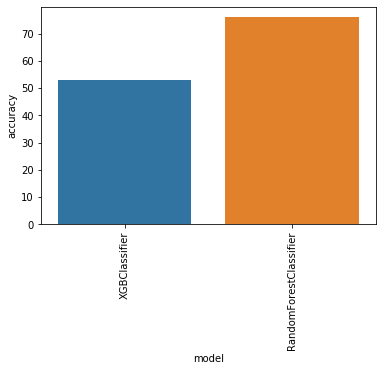

In [0]:
rfc_val = perform_rfc(X, y, test_X)
xgb_val = perform_xgb(X, y, test_X)
    
model_accuracies = pd.DataFrame()
model_accuracies = model_accuracies.append([rfc_val, xgb_val])
cols = list(model_accuracies.columns.values)
cols = cols[-1:] + cols[:-1]
model_accuracies = model_accuracies[cols]
model_accuracies = model_accuracies.sort_values(by='accuracy')
print(model_accuracies)
plt.figure()
plt.xticks(rotation=90)
sns.barplot(x='model', y='accuracy', data=model_accuracies)

# **<font color='blue'>Predicting output**</font>

In [0]:
lg = RandomForestClassifier(n_estimators=100, oob_score=True, max_features=None).fit(X, y)
y_pred = lg.predict(test_X)
test_X['accuracy_group'] = y_pred
test_X['accuracy_group'] = test_X['accuracy_group'].astype('int')
test_X['installation_id'] = test_df_subset['installation_id']
final_df = test_X[['installation_id', 'accuracy_group']]
final_df.to_csv('submission.csv', sep=',', index=False)

# **<font color='blue'>Summary**</font>

RandomForestClassifier outperfroms XGBoost and has a socre of ... on LB.